In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
from heapq import nlargest

%pylab inline

# from IPython.display import Image
# from IPython.display import clear_output
# pl.rcParams['font.size'] = 20
# Image(filename = "Ridetypes.png")

Populating the interactive namespace from numpy and matplotlib


# To download data, un-comment cellblock below

In [3]:
#!wget https://github.com/fedhere/PUI2018_fb55/blob/master/HW11_fb55/MTA_Fare.npy?raw=true MTA_Fare.npy

In [4]:
mta = np.load('MTA_Fare.npy?raw=true')

In [5]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [6]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [7]:
mta = mta.astype(float)
mta[mta == -1] = np.nan
len(mta[mta == -1])

0

In [8]:
# creating date range 05/19/2010 to 02/19/2014
# there are no dates in the data, just numbers 

dates = pd.date_range(start='05/19/2010', periods=194, freq='W')
dates

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

In [9]:
mta_stations = np.nansum(mta, axis = 1) #collapse by card type
mta_stations.shape

(600, 194)

In [12]:
mta_stations.shape

(600, 194)

In [13]:
stations = pd.DataFrame(mta_stations, columns=pd.date_range(start='05/09/2010', periods=194, freq='W'))
stations.head()

,2010-05-09 00:00:00,2010-05-16 00:00:00,2010-05-23 00:00:00,2010-05-30 00:00:00,2010-06-06 00:00:00,2010-06-13 00:00:00,2010-06-20 00:00:00,2010-06-27 00:00:00,2010-07-04 00:00:00,2010-07-11 00:00:00,...,2013-11-17 00:00:00,2013-11-24 00:00:00,2013-12-01 00:00:00,2013-12-08 00:00:00,2013-12-15 00:00:00,2013-12-22 00:00:00,2013-12-29 00:00:00,2014-01-05 00:00:00,2014-01-12 00:00:00,2014-01-19 00:00:00
0,126878.0,149477.0,152383.0,160175.0,162641.0,156414.0,159156.0,159374.0,163285.0,159252.0,...,87973.0,83825.0,91001.0,80908.0,79891.0,69881.0,79550.0,78901.0,74591.0,76833.0
1,37306.0,46464.0,49359.0,44849.0,41509.0,35654.0,41989.0,41909.0,41214.0,41142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6606.0,6881.0,7229.0,5731.0,7032.0,5107.0,5497.0,5668.0,5555.0,6942.0,...,8268.0,5928.0,5656.0,7665.0,8377.0,7343.0,7743.0,8171.0,7907.0,6790.0
3,16378.0,17408.0,17595.0,14242.0,17589.0,13168.0,14510.0,14388.0,14221.0,17180.0,...,23450.0,16228.0,15586.0,21806.0,23534.0,20604.0,21370.0,22459.0,22773.0,19033.0
4,18564.0,19903.0,19948.0,16076.0,20283.0,14601.0,16151.0,16066.0,16205.0,19619.0,...,23025.0,18253.0,17293.0,21484.0,22516.0,20560.0,21942.0,23283.0,22987.0,21562.0


In [14]:
sample_rate = 1 #in the array, we have weekly card swipes, so our sample rate is weekly
duration = 194
N = duration * sample_rate

In [15]:
# find the freq that corresponds to 52 weeks

f_annual = 1/np.fft.rfftfreq(194, 1.0)
f_annual

array([          inf,  194.        ,   97.        ,   64.66666667,
         48.5       ,   38.8       ,   32.33333333,   27.71428571,
         24.25      ,   21.55555556,   19.4       ,   17.63636364,
         16.16666667,   14.92307692,   13.85714286,   12.93333333,
         12.125     ,   11.41176471,   10.77777778,   10.21052632,
          9.7       ,    9.23809524,    8.81818182,    8.43478261,
          8.08333333,    7.76      ,    7.46153846,    7.18518519,
          6.92857143,    6.68965517,    6.46666667,    6.25806452,
          6.0625    ,    5.87878788,    5.70588235,    5.54285714,
          5.38888889,    5.24324324,    5.10526316,    4.97435897,
          4.85      ,    4.73170732,    4.61904762,    4.51162791,
          4.40909091,    4.31111111,    4.2173913 ,    4.12765957,
          4.04166667,    3.95918367,    3.88      ,    3.80392157,
          3.73076923,    3.66037736,    3.59259259,    3.52727273,
          3.46428571,    3.40350877,    3.34482759,    3.28813

Text(0.5,1,'Power Spectrum: 600 stations in Manhattan')

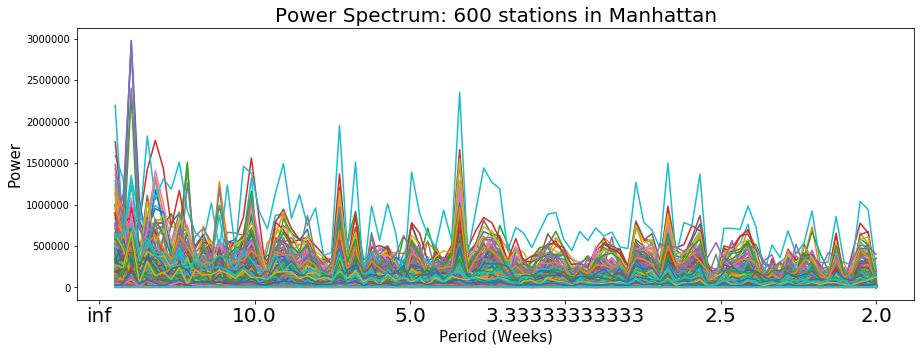

In [16]:
N = len(mta_stations[1])
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)

# Create a dictionary to store the frequency bin centers in cycles per week (x axis)
# and the Fourier Transform value (Y) for each of the stations

mta_stations_per = {}

for i in range (len(mta_stations)):
    f = np.abs(np.fft.rfft(mta_stations[i]))
    ffreq = np.fft.rfftfreq(N, 1.0)
    #mta_stations_power[i]=(ffreq,f)
    ax.plot(ffreq[2:], (f[2:]), '-')
    mta_stations_per[i]=((f[4]))

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Period (Weeks)", fontsize=15)
pl.ylabel("Power", fontsize=15)

ax.set_title('Power Spectrum: 600 stations in Manhattan', fontsize=20)

Figure 1: Power spectrum for all 600 subway stations in Manhattan, across all 23 card types. The spikes indicate significant periodicity. 

In [17]:
# getting four largest values from the dictionary 
top4 = nlargest(4, mta_stations_per, key=mta_stations_per.get)
print('four stations with most prominent annual periodicity', top4)

four stations with most prominent annual periodicity [0, 194, 150, 327]


Text(0.5,1,'Power Spectrum: 600 stations in Manhattan')

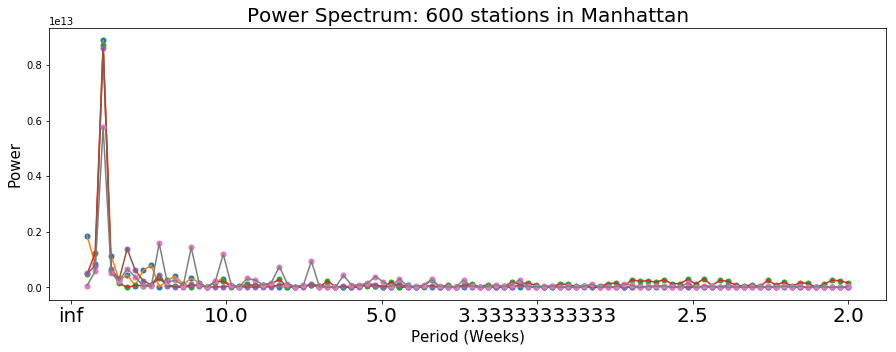

In [18]:
#plot the time series for the four stations with the most prominent periodic trends 

fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in range(len(top4)):
    f = np.abs(np.fft.rfft(mta_stations[top4[i]]))**2
    ffreq = np.fft.rfftfreq(N, 1.0)
    ax.plot(np.fft.rfftfreq(N, 1.0)[2:], (f[2:]), 'o', ms=5)
    ax.plot(np.fft.rfftfreq(N, 1.0)[2:], (f[2:]), '-', label='Station ' + str(top4[i]))
    mta_stations_per[i]=((f[4]))

ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Period (Weeks)", fontsize=15)
pl.ylabel("Power", fontsize=15)

ax.set_title('Power Spectrum: 600 stations in Manhattan', fontsize=20)

Figure 2: Isolating the four stations with the most periodic trends. 

<function matplotlib.pyplot.xticks>

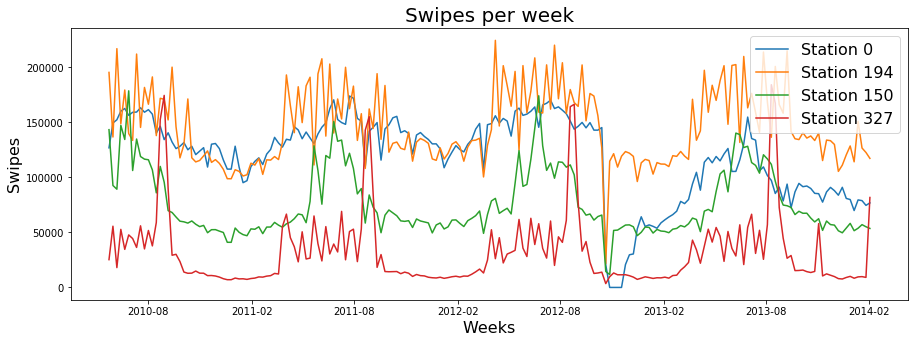

In [19]:
#plotting the station swipes and dates to try to find possible events that explain periodicity

fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)

for i in range(len(top4)):
    ax.plot(dates, mta_stations[top4[i]], '-', label='Station ' + str(top4[i]))

plt.xlabel('Weeks', fontsize=16)
plt.ylabel('Swipes', fontsize=16)
ax.legend(loc='best', fontsize=16)
pl.title('Swipes per week', fontsize=20)
pl.xticks

Figure 3: The 4 stations with the most prominent annual periodicity (station 0, 150, 194, and 327). These stations experience an annual periodicity in the summer months, which could indicate these are perhaps outdoor stations that are much more frequently used in the summer, or stations that feed into warm-weather destinations, such as near parks or summer attractions. 